In [13]:
import pathlib
import pandas as pd
from sklearn.pipeline import make_pipeline 
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from embetter.grab import ColumnGrabber
from embetter.vision import ImageLoader, ColorHistogramEncoder, TimmEncoder

image_emb_pipeline = make_pipeline(
  ColumnGrabber("path"),
  ImageLoader(convert="RGB"),
  TimmEncoder("xception", encode_predictions=True),
)

/home/oren/projects/koaning_bulk_images/venv/lib/python3.8/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [14]:
# Make dataframe with image paths
cat_paths = pathlib.Path("catdog", "cat").glob("*")
dog_paths = pathlib.Path("catdog", "dog").glob("*")

dataf = pd.concat([
    pd.DataFrame({"path": [str(p) for p in cat_paths], "label": "cat"}),
    pd.DataFrame({"path": [str(p) for p in dog_paths], "label": "dog"})
])

# Make csv file with Umap'ed model layer 
X = image_emb_pipeline.fit_transform(dataf)
y = dataf['label'] == "cat"
X.shape

(30, 1000)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
def make_model():
    inputs = keras.Input(shape=(None, X.shape[1]))
    x = layers.Dense(50, activation="sigmoid")(inputs)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs), keras.Model(inputs, x)

In [17]:
pred_model, emb_model = make_model()

epochs = 25

pred_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [18]:
pred_model.fit(x=X, y=y, epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 471ms/step - loss: 0.6770 - accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6341 - accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6139 - accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.5939 - accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.5746 - accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.5561 - accuracy: 0.7000
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.5384 - accuracy: 0.7000
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.5211 - accuracy: 0.7000
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 0.5044 - accuracy: 0.7333


In [19]:
# Make dataframe with image paths
paths = pathlib.Path("downloads", "pets").glob("*")
dataf_all = pd.DataFrame({"path": [str(p) for p in paths]})

# Make csv file with Umap'ed model layer 
X_all = image_emb_pipeline.fit_transform(dataf_all)

In [20]:
X_tfm = UMAP().fit_transform(X_all)

In [21]:
X_tfm_fine = UMAP().fit_transform(emb_model.predict(X_all))

16/16 [==============================] - 0s 1ms/step


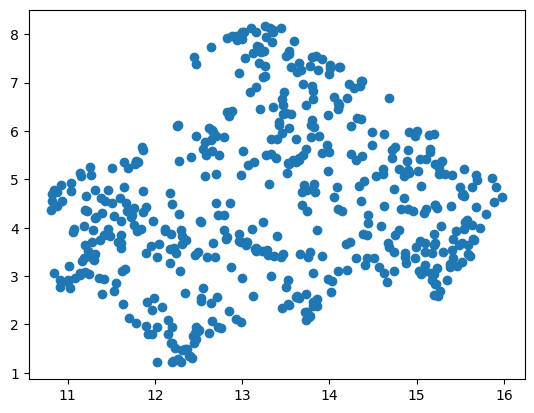

In [22]:
import matplotlib.pylab as plt

plt.scatter(X_tfm[:, 0], X_tfm[:, 1])

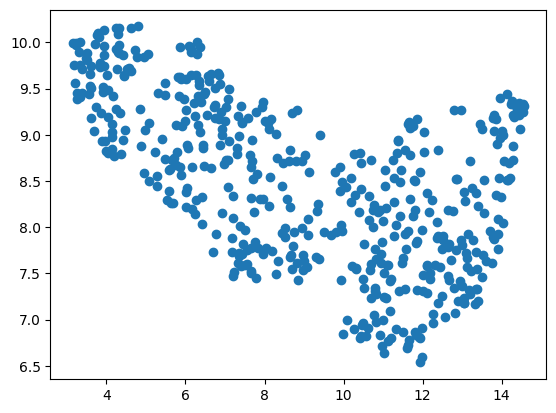

In [23]:
plt.scatter(X_tfm_fine[:, 0], X_tfm_fine[:, 1])

In [24]:
dataf_all.assign(x=X_tfm[:, 0], y=X_tfm[:, 1]).to_csv("pets-orig.csv")
dataf_all.assign(x=X_tfm_fine[:, 0], y=X_tfm_fine[:, 1]).to_csv("pets-finetuned.csv")